In [1]:
import sys
import os
import json
import base64
from pathlib import Path
import pandas as pd
from io import BytesIO
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import DocumentStream
from docling_core.types.doc import ImageRefMode
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption


notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..')))

from dotenv import load_dotenv
load_dotenv()
from backend.utils.aws.s3 import get_s3_client, read_pdf_from_s3, write_image_to_s3, write_image_to_s3_nopage, write_markdown_to_s3

d:\NEU\SPRING_25\BIG_DATA\data-extraction-and-standardization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = "https://sfopenaccessbucket.s3.us-east-1.amazonaws.com/uploads/649af4f1-a280-43b3-8135-1664e7db178b.pdf"
parent_file = url.split('/uploads/')[1]
pdf_data = read_pdf_from_s3(get_s3_client(),url )
buf = BytesIO(pdf_data)
source = DocumentStream(name=parent_file, stream=buf)
IMAGE_RESOLUTION_SCALE = 2.0
pipeline_options = PdfPipelineOptions()
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)
conv_res = converter.convert(source)
picture_counter=0
output_dir=Path('artifacts/docling')
output_dir.mkdir(parents=True, exist_ok=True)
doc_filename = conv_res.input.file.stem

md_filename = output_dir / f"{doc_filename}.md"
conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.EMBEDDED)
# result = conv_res.document.export_to_markdown(image_mode=ImageRefMode.EMBEDDED)

In [3]:
with open(md_filename, 'rb') as f:
    d = f.read().decode('utf-8')  # d will be a string

In [4]:
d_lst = d.split("\n")

['\r',
 '\r',
 '## Contents\r',
 '\r',
 '| A Message from the Secretary of the Treasury ............................................................................1                                                                                                                                                    |\r',
 '|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|\r',
 '| General Accounting Office Report                                                                                                                                                                                                                                              |\r',
 "| Comptroller General's Statement .....................................................................................
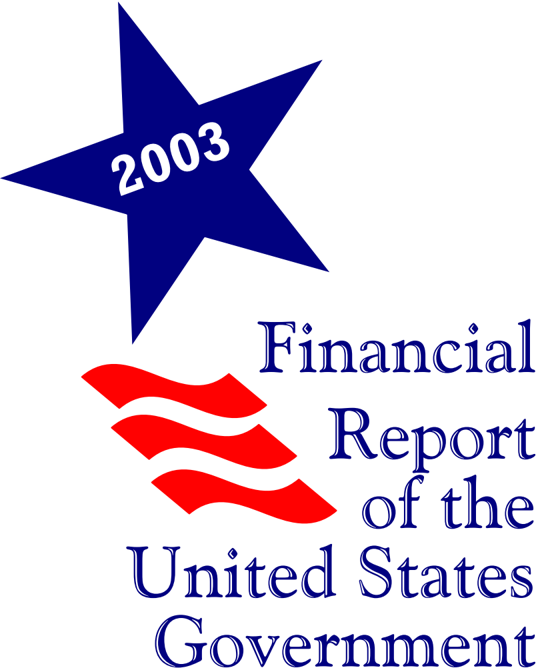
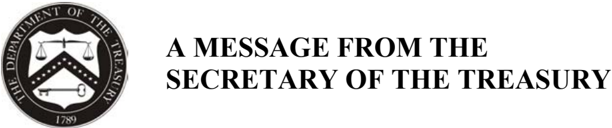
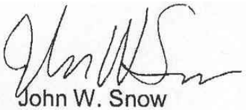
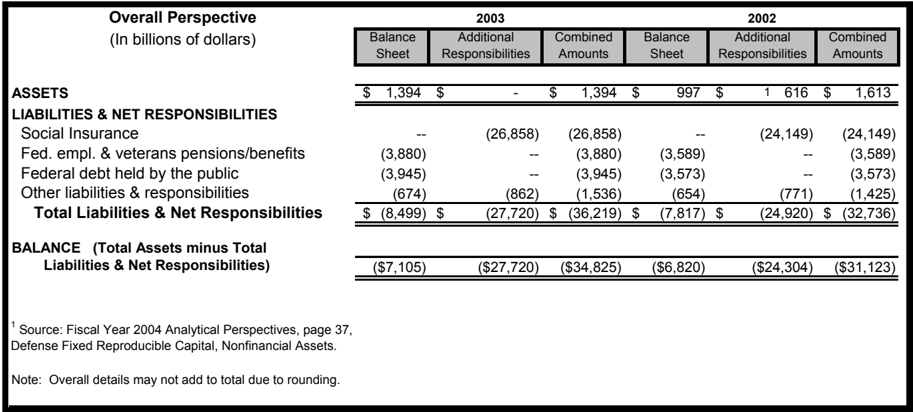
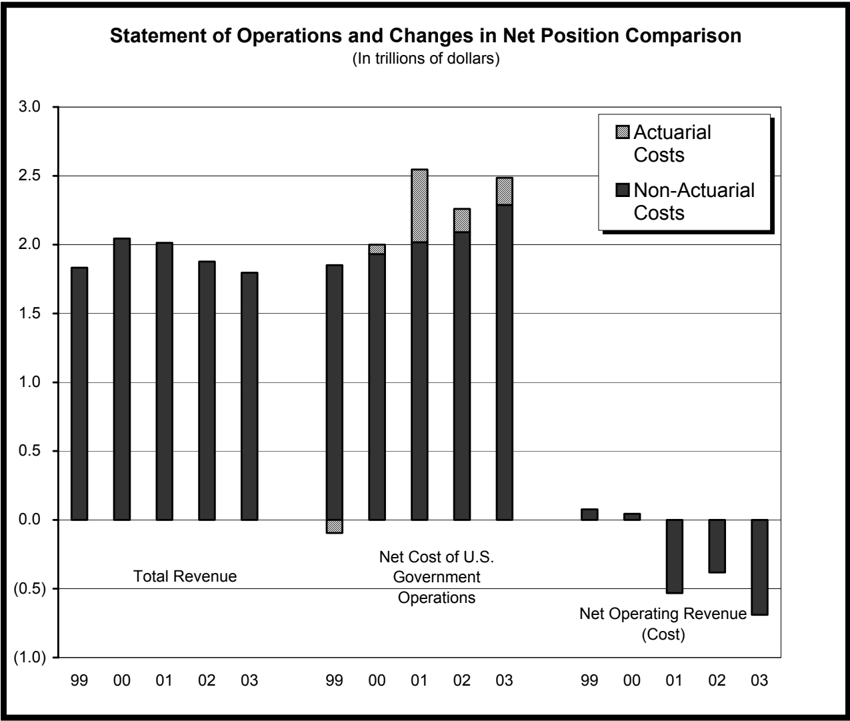
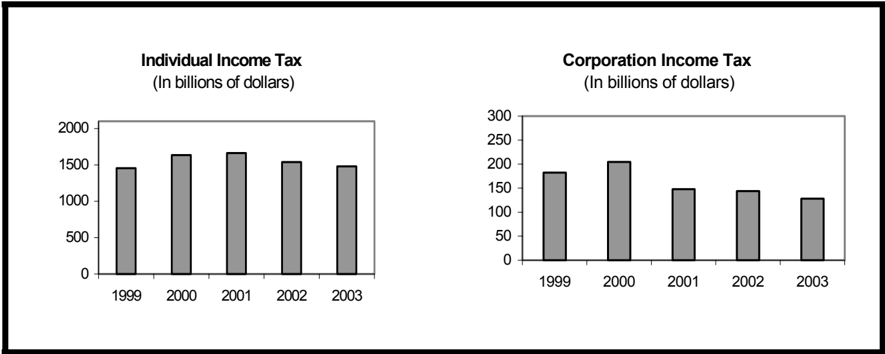
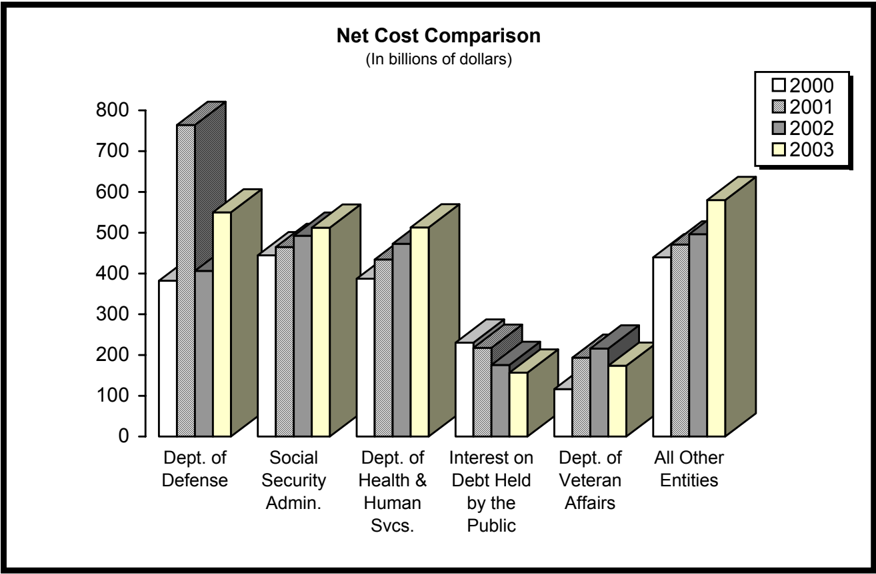
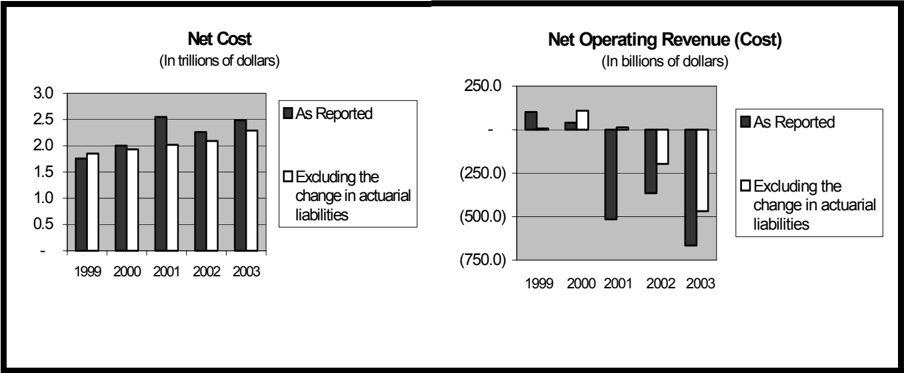
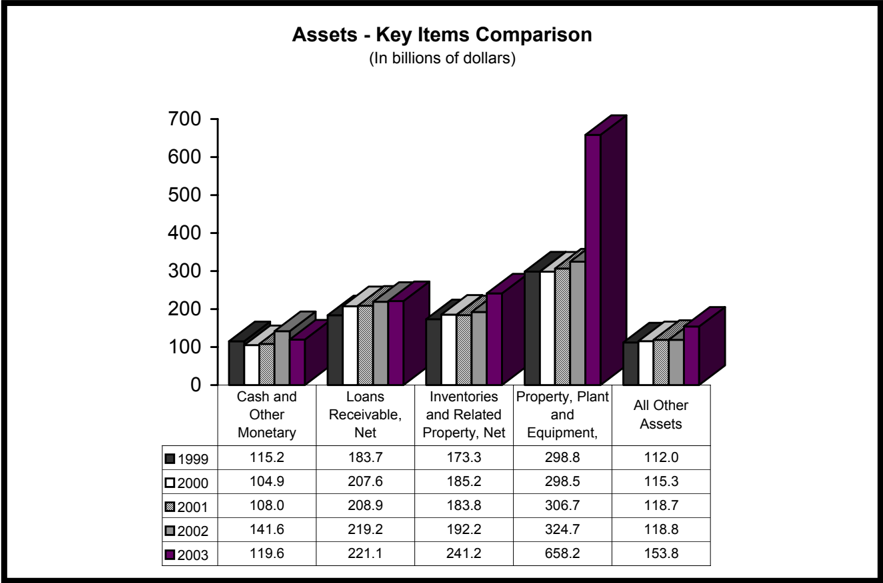
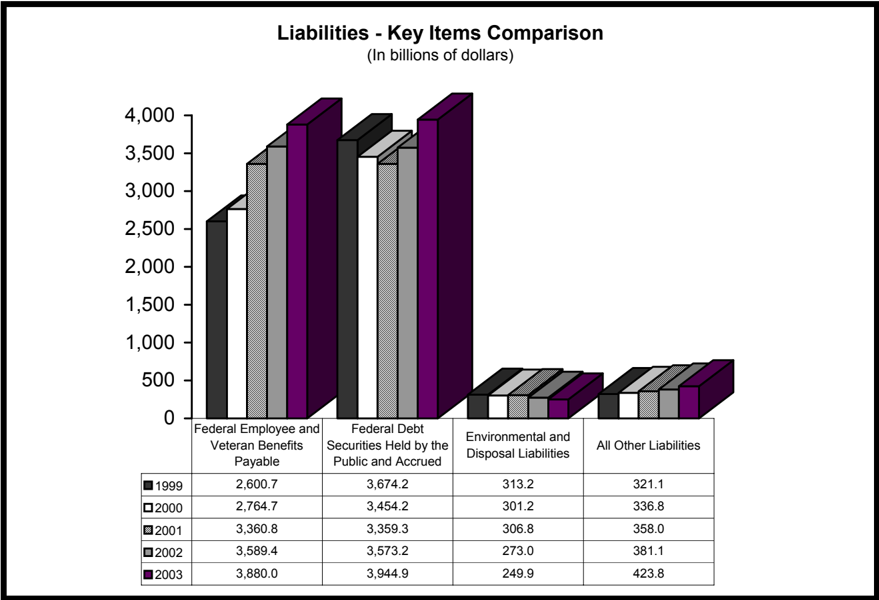
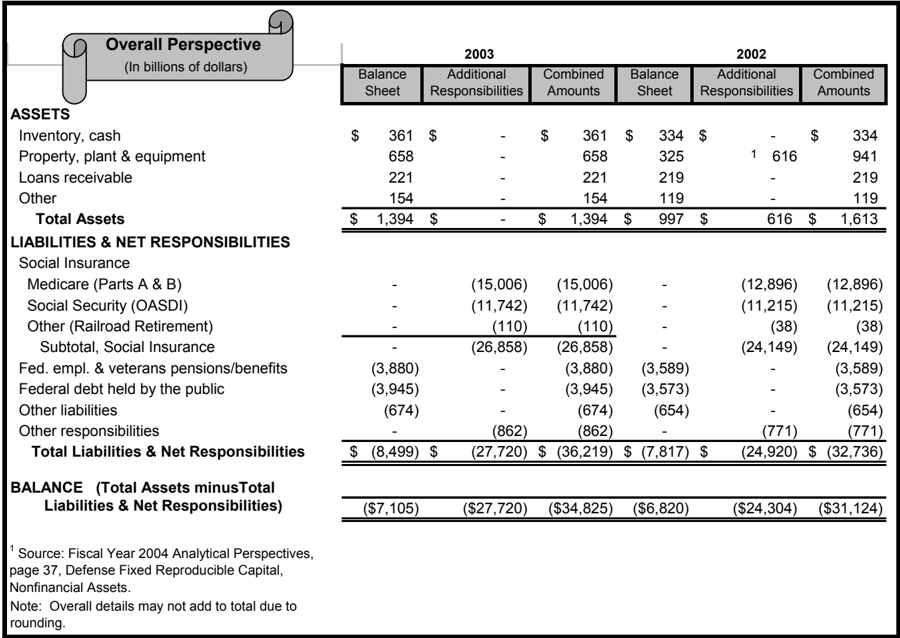

In [5]:
d_lst

In [6]:
s3_client = get_s3_client()

In [13]:
for i,d in enumerate(d_lst):
    if '![Image]' in d:
        base64_string = d_lst[i].split('![Image](data:')[1].split(',')[1]
        image_bytes = base64.b64decode(base64_string)
        object_url = write_image_to_s3_nopage('docling', s3_client, image_bytes, parent_file)
        d_lst[i] = f'![Image]({object_url})'
        

In [16]:
d_mod = "\n".join(d_lst)

In [18]:
write_markdown_to_s3('docling', s3_client, d_mod, parent_file)

In [2]:
from backend.utils.docling.markdown import PDF2MD 

In [3]:
url = "https://sfopenaccessbucket.s3.us-east-1.amazonaws.com/uploads/649af4f1-a280-43b3-8135-1664e7db178b.pdf"
PDF2MD(get_s3_client(), url=url)

'https://sfopenaccessbucket.s3.us-east-1.amazonaws.com/results/docling/649af4f1-a280-43b3-8135-1664e7db178b/content.md'